# Terrain Classification - General Data
### Created by Keenan McConkey 2019.8.12

In [1]:
from __future__ import absolute_import, division, print_function

import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal
from scipy import stats

from datetime import datetime
from decimal import Decimal

import pymrmr
import sklearn

## Part 1 - Importing Datasets

### Part (0) - Functions for Data Import

In [2]:
# Easier to read column names
std_columns = ['X Accel', 'Y Accel', 'Z Accel', 'X Gyro', 'Y Gyro', 'Z Gyro', 'Run Time', 'Epoch Time']
data_columns =  ['X Accel', 'Y Accel', 'Z Accel', 'X Gyro', 'Y Gyro', 'Z Gyro']
synthesis_columns = ['Calc X Vel', 'Calc Z Gyro', 'Run Time', 'Epoch Time',
                     'Left X Accel', 'Left Y Accel', 'Left Z Accel', 'Left XY Accel', 
                     'Left X Gyro','Left Y Gyro', 'Left Z Gyro',
                     'Right X Accel', 'Right Y Accel', 'Right Z Accel', 'Right XY Accel',
                     'Right X Gyro', 'Right Y Gyro', 'Right Z Gyro']

# Columns not currently used for classification
unused_columns = ['Time Received', 'Timestamp', 'Pitch (Deg)', 'Roll (Deg)', 'Heading (Deg)',
                  'MagX', 'MagY', 'MagZ', 'ACCELEROMETER XY (m/s²)']
# Differs for synthesis data (as usual)
unused_columns_synth = ['ACCELEROMETER X (m/s²)']

'''Get columns for given label'''
def get_columns(label):
    # Columns differ for synthesis data
    if 'Middle' in label or 'Left' in label or 'Right' in label:
        columns = std_columns.copy()
    elif 'Synthesis' in label:
        columns = synthesis_columns.copy()
    else:
        raise Exception('Unknown label')
    
    # For transformed datasets replace time columns with frequency
    if 'FFT' in label or 'PSD' in label:
        columns.remove('Epoch Time')
        
        if 'Run Time' in columns:
            columns.remove('Run Time')
        
        columns.append('Frequency')
        
    return columns

In [3]:
# Types of terrains, placements, and transforms used
terrains = ['Concrete', 'Carpet', 'Linoleum', 'Asphalt', 'Sidewalk', 'Grass', 'Gravel']
placements = ['Left', 'Right', 'Middle', 'Synthesis']
transforms = ['FFT', 'PSDLog', 'PSD']
movements = ['F8', 'Donut', 'Straight']

'''Get the integer terrain value of a given label'''
def get_terrain_num(_label):
    for i, terrain in enumerate(terrains):
        if terrain in _label:
            return i
        
    raise Exception('Unknown terrain')

'''Get the name associated with a terrain integer'''
def get_terrain_name(terrain_num):
    return terrains[terrain_num]

'''Get the placement location name for given label'''
def get_placement(_label):
    for placement in placements:
        if placement in _label:
            return placement
    
    raise Exception('Unknown placement')

'''Get the transform used for given label'''
def get_transform(_label):
    for transform in transforms:
        if transform in _label:
            return transform
    
    raise Exception('Unkown transform')

### Part (a) - Parsing Data into Pandas

In [4]:
# Find .csv files
raw_datasets = {}
glob_paths = glob.glob('imu_data/new_setup/set_manual/*.csv')

# Remove 9250 IMU data (for now)
dataset_paths = [path for path in glob_paths if '9250' not in path]

In [5]:
# Import datasets as a dictionary of Pandas DataFrames
for dataset_path in dataset_paths:
    
    # Parse labels from filenames
    dataset_label = dataset_path.split('/')[-1].split('.')[0]    

    # Read from CSV to Pandas
    dataset = pd.read_csv(dataset_path)
    
    # Drop unused columns
    if 'Synthesis' in dataset_label:
        unused = [unused_column for unused_column in unused_columns_synth if unused_column in dataset.columns]
    else:
        unused = [unused_column for unused_column in unused_columns if unused_column in dataset.columns]
    dataset = dataset.drop(unused, axis='columns')
    
    # Rename columns to easier to work with names
    dataset.columns = get_columns(dataset_label)

    # Convert timestamps to epoch time in sec
    dataset['Epoch Time'] = dataset['Epoch Time'].apply(datetime.strptime, args=("%Y-%m-%d %H:%M:%S:%f", ))
    dataset['Epoch Time'] = dataset['Epoch Time'].apply(datetime.timestamp)
    
    # Remove gravitational acceleration from Middle frame data
    ## Can't remove from wheel-mounted Left and Right wheel data because they rotate over time
    if 'Middle' in dataset_label:
        # Remove gravity from z component of acceleration, 
        g_z = 9.81
        dataset['Z Accel'] = dataset['Z Accel'].apply(lambda x: x - g_z)

    # Remove dropped bytes - i.e. run times below zero
    #dataset = dataset.drop(dataset.loc[dataset['Run Time'] < 0].index.values.tolist())

    # Reorganize synthesis data columns to put Run Time and Epoch Time at the end
    if 'Synthesis' in dataset_label:
        dataset_columns = dataset.columns.tolist()
        dataset_columns = dataset_columns[:3] + dataset_columns[5:] + dataset_columns[3:5]
        dataset = dataset[dataset_columns]
    
    # Trim edges to account for start and end time
    # Use different axes to check threshold for synthesis data
    if 'Synthesis' in dataset_label:
        thresh_axes = 'Calc X Vel'
        STARTUP_THRESH = 0.1
    else:
        thresh_axes = 'Z Accel'
        STARTUP_THRESH = 2.0
        
    # Caluclate first and last instance above threshold and use as the time domain
    start_index = dataset[dataset[thresh_axes] > STARTUP_THRESH].index[0]
    stop_index = dataset[dataset[thresh_axes] > STARTUP_THRESH].index[-1]
    dataset = dataset[start_index:stop_index]
    
    # Datasets are stored in a dictionary
    raw_datasets.update({dataset_label: dataset})

In [6]:
# Update order of synthesis columns
synthesis_columns = ['Calc X Vel', 'Calc Z Gyro',
                     'Left X Accel', 'Left Y Accel', 'Left Z Accel', 'Left XY Accel', 
                     'Left X Gyro','Left Y Gyro', 'Left Z Gyro',
                     'Right X Accel', 'Right Y Accel', 'Right Z Accel', 'Right XY Accel',
                     'Right X Gyro', 'Right Y Gyro', 'Right Z Gyro',
                     'Run Time', 'Epoch Time']

In [7]:
# Sort dictionary according to keys
raw_datasets = {label: raw_datasets[label] for label in sorted(raw_datasets.keys())}

# Save list of keys to variable
dataset_labels = list(raw_datasets.keys())
print('Number of raw datasets: {}'.format(len(dataset_labels)))

Number of raw datasets: 333


In [8]:
# Check dataset formatting
raw_datasets[dataset_labels[0]].head()

,X Accel,Y Accel,Z Accel,X Gyro,Y Gyro,Z Gyro,Run Time,Epoch Time
2971,-6.697752,-8.063040,2.459991,-0.721819,-0.570255,1.892346,8.915,1.565202e+09
2972,-7.295096,-8.195917,-0.677562,-0.720754,-0.548417,1.924037,8.918,1.565202e+09
2973,-6.226102,-7.138893,-2.937654,-0.666692,-0.510068,1.951202,8.921,1.565202e+09
2974,-5.175063,-7.549492,-1.483198,-0.668023,-0.519922,1.974638,8.924,1.565202e+09
2975,-4.813545,-7.622514,2.151144,-0.694921,-0.514595,2.010058,8.927,1.565202e+09


### Part (b) - Visualizing Time Domain Data

In [9]:
'''Plot a single Pandas dataset for given x and y axes'''
def plot_one(_datasets, dataset_name, x_axis, y_axis, xlim=None, ylim=None, save_fig=False):
    # Figure parameters
    plt.clf()
    plt.figure(figsize=(10, 5))
    plt.title(dataset_name)
    plt.xlabel(x_axis + ' (s)')
    
    # Add relevant units to y label
    if 'Accel' in y_axis:
        plt.ylabel(y_axis + ' ($m/s^2$)')
    elif 'Gyro' in y_axis:
        plt.ylabel(y_axis + ' ($rad/s$)')
    elif 'Vel' in y_axis:
        plt.ylabel(y_axis + ' ($m/s$)')
    else:
        plt.ylabel('Unknown')
    
    # Use limits if they've been passed in
    if xlim is not None:
        plt.xlim(xlim[0], xlim[1])
    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])
    
    # Plot relevant data
    plt.plot(_datasets[dataset_name][x_axis], _datasets[dataset_name][y_axis])
    
    # Save figure to png file without plotting
    if save_fig:
        save_name = '/home/caris/Wheelchair-Terrain-Classification/imgs/'
        save_name = save_name + y_axis.replace(' ', '_') + '_' + dataset_name + '.png'
        plt.savefig(save_name)
    
    # Just plot without saving
    else:    
        plt.show()

In [ ]:
# Plot some raw data
plot_one(raw_datasets, dataset_labels[0], 'Run Time', 'X Accel')

In [11]:
# Plot every dataset Z Accel and save images
#for label in dataset_labels:
#    plot_one(raw_datasets, label, 'Run Time', 'Z Accel', save_fig=True)

In [12]:
'''Compare two Pandas datasets by Epoch Time'''
def dataset_compare(dataset1, label1, dataset2, label2, y_axis, t_offset=0, y_offset=0):
    # Plot parameters
    plt.clf()
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.set_xlabel('Epoch Time ($s$)')
    ax.set_title(y_axis + ' for ' + label1 + ' and ' + label2)
        
    # Add relevant units to y label
    if 'Gyro' in y_axis:
        ax.set_ylabel(y_axis + ' ($rad/s$)')
    elif 'Accel' in y_axis:
        ax.set_ylabel(y_axis + ' ($m/s^2$)')
    elif 'Vel' in y_axis:
        ax.set_ylabel(y_axis + ' ($m/s$)')
    else:
        ax.set_ylabel('Unknown')
    
    # Plot data with given y and t offsets applied to first dataset
    ax.plot(dataset1[label1]['Epoch Time'].apply(lambda t: t + t_offset), 
            dataset1[label1][y_axis].apply(lambda y: y + y_offset), label=label1)
    ax.plot(dataset2[label2]['Epoch Time'], 
            dataset2[label2][y_axis], label=label2)
    
    # Include offset info text in plot
    offset_text = 'Offsets\n'
    offset_text += ': t={}'.format(t_offset) + ', ' + 'y={}'.format(y_offset)
    ax.text(0.05, 0.05, s=offset_text, 
            horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)
    
    ax.legend()
    plt.show()

In [13]:
# Compare Z Gyro data for each wheel in the same dataset
#dataset_compare(raw_datasets, 'Left_ConcreteStraightKevin_Module',
#                raw_datasets, 'Right_ConcreteStraightKevin_Module', 
#                dirn='Z Gyro')

In [14]:
'''Plot given x and y axes for every Pandas DataFrame in given array of datasets'''
def plot_all(_datasets, x_axis, y_axis, windowed=False, win_num=0, take_row=False):
    plt.clf()
    
    # Set paramaeters based on number of datasets to plot
    n_axes = len(_datasets)
    odd_axes = n_axes % 2 == 0
    rows = int((n_axes + 1) / 2)
    
    # Scale approriately
    if (odd_axes):
        fig = plt.figure(figsize=(n_axes*5, n_axes*3))          
    else:
        fig = plt.figure(figsize=(n_axes*5, n_axes*2))
    
    # Grid of subplots
    gs = gridspec.GridSpec(rows, 2)
    axes = []
    row, col = 0, 0
    
    # Plot each of the given datasets
    for i, (label, dataset) in enumerate(_datasets.items()):
        # Take a whole row if odd num of axes
        if (i == n_axes-1 and odd_axes and take_row): 
            axes.append(fig.add_subplot(gs[row, :]))
        else:
            axes.append(fig.add_subplot(gs[row, col]))
        
        # Plot on new subplot
        if (windowed):
            axes[i].plot(dataset[win_num][x_axis], dataset[win_num][y_axis])
        else:
            axes[i].plot(dataset[x_axis], dataset[y_axis])
        axes[i].set_title(label)
        axes[i].set_xlabel(x_axis + ' (s)')
        
        if 'Gyro' in y_axis:
            axes[i].set_ylabel(y_axis + ' ($rad/s$)')
        elif 'Accel' in y_axis:
            axes[i].set_ylabel(y_axis + ' ($m/s^2$)')
        
        # Only go two columns wide
        col += 1
        if (col == 2):
            row += 1
            col = 0
        
    plt.subplots_adjust(hspace=0.35, wspace=0.15)
    plt.show()

<Figure size 432x288 with 0 Axes>

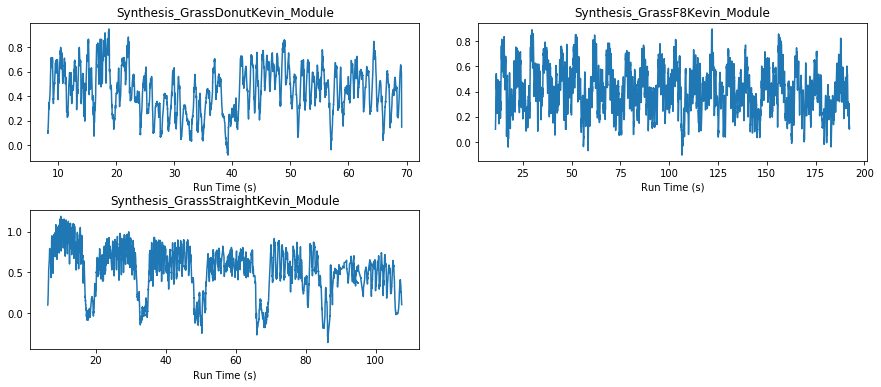

In [15]:
# Plot Z Accel of same dataset for different modules
datasets_to_plot = {label: dataset for label, dataset in raw_datasets.items() if 'Synthesis' in label and 'Grass' in label and 'Kevin' in label}
plot_all(datasets_to_plot, x_axis='Run Time', y_axis='Calc X Vel')

### Part (c) - Converting Between Pandas and Numpy

In [16]:
'''Convert array of Pandas DataFrames to array of 2D NumPy array'''
def pd_to_np(pd_datasets, windowed=False):
    np_datasets = {}
    
    # Convert each dataset individually
    for label, dataset in pd_datasets.items():
        np_dataset = []
        
        # Return passed datasets if they are already NumPy ndarrays
        if type(dataset) is np.ndarray:
            print('Note: Already a NumPy array!')
            return pd_datasets
        
        # If windowed, convert individual windows to Pandas
        if (windowed):
            for window in dataset:
                np_dataset.append(window.as_matrix()) 
        else:
            np_dataset = dataset.to_numpy()
        
        np_datasets.update({label: np_dataset})
        
    return np_datasets

In [17]:
'''Convert array of 2D NumPy arrays to Pandas Data Frames'''
def np_to_pd(np_datasets, windowed=False):
    pd_datasets = {}
    
    # Convert each dataset individually
    for label, dataset in np_datasets.items():
        pd_dataset = []
        
        # Return passed datasets if they are already Pandas dataframes
        if type(dataset) is pd.DataFrame:
            print('Note: Already a Pandas dataframe!')
            return np_datasets
        
        # Use correct column names
        new_columns = get_columns(label)
            
        # If windowed, convert individual windows to Pandas
        if (windowed):
            for window in dataset:
                pd_dataset.append(pd.DataFrame(data=window, columns=new_columns))     
        else:
            pd_dataset = pd.DataFrame(data=dataset, columns=new_columns)
            
        pd_datasets.update({label: pd_dataset})
    
    return pd_datasets

In [18]:
# Convert to NumPy
raw_datasets = pd_to_np(raw_datasets)

In [19]:
# Run to convert back to Pandas
#raw_datasets = np_to_pd(raw_datasets)

In [20]:
# Check if its constructed correctly
print('Number of datasets: {}'.format(len(raw_datasets)))
print('Shape of first dataset: {}'.format(raw_datasets[dataset_labels[0]].shape))

Number of datasets: 333
Shape of first dataset: (20222, 8)


#### Data Structure:

`Terrain Dataset Dictionary 
-> NP Array
---> Row = Datapoint, 
---> Col = Direction | Time`

## Part 2 - Preprocessing

In [21]:
'''Get relevant frequencies for given label based on whether its a frame or wheel dataset'''
def get_frequencies(label):
    # Sampling frequency (and thus cutoff frequency) varies between frame and wheel modules
    if 'Left' in label or 'Right' in label or 'Synthesis' in label:
        f_samp = 333.3 # Sampling frequency
        f_low = 60 # Low pass cutoff frequency
        f_high = 1 # High pass cutoff frequency
    elif 'Middle' in label:
        f_samp = 300 # Sampling frequency
        f_low = 55 # Low pass cutoff frequency
        f_high = 1 # High pass cutoaff frequency
    else:
        raise Exception('Unknown label')
        
    return f_samp, f_low, f_high

In [22]:
'''Get window size based on whether label is for a frame or wheel dataset'''
def get_window_size(label):
    # Sampling frequency differs varies between frame and wheel modules
    # Synthesis data is created from combining left and right wheel data so it has the same samp rate
    if 'Left' in label or 'Right' in label or 'Synthesis' in label:
        window_size = 333
    elif 'Middle' in label:
        window_size = 300
    else:
        raise Exception('Unknown label')
        
    return window_size

In [23]:
'''Get number of data columns in dataset with given label'''
def get_n_data_col(label):
    # Different number of columns for Synthesis datasets
    if 'Synthesis' in label:
        n_col = 16
    elif 'Left' in label or 'Right' in label or 'Middle' in label:
        n_col = 6
    else:
        raise Exception('Unknown label')
    return n_col

### Part (a) - Butterworth Filtering

Butterworth filters can be high-pass/low-pass/bandpass, and attempt to have maximally flat frequency response in bandpass.

Changing the *cutoff frequency* of the filter affects the smoothness of the graph and amount of ringing. 

Changing the *order* of the filter can have significant effects on smoothness depending on the cutoff frequency. 

**Nominally set to 30 % of Nyquist Freq**

In [24]:
# Filtered datasets dictionary
datasets = {}

# Filter each dataset individually
for label, raw_dataset in raw_datasets.items():
    # Sampling rates are not consistent across all datasets
    f_samp, f_low, f_high = get_frequencies(label)
    
    # Get normalized frequencies
    w_low = f_low / (f_samp / 2) 
    w_high = f_high / (f_samp / 2)

    # Get Butterworth filter parameters
    b_butter, a_butter = signal.butter(N=4, Wn=w_low, btype='low')
    
    # Number of columns containing data
    n_data_col = get_n_data_col(label)
    
    # Filter all the data columns
    dataset = np.copy(raw_dataset)
    for i in range(n_data_col):
        dataset[:, i] = signal.filtfilt(b_butter, a_butter, dataset[:, i])
        
    datasets.update({label: dataset})

In [25]:
# Check construction of filtered dataset
print('Num filtered datasets: {}'.format(len(datasets)))
print('Shape of first filtered dataset: {}'.format(datasets[dataset_labels[0]].shape))

Num filtered datasets: 333
Shape of first filtered dataset: (20222, 8)


In [26]:
# Verify we can convert back to Pandas
np_to_pd(datasets, windowed=False)[dataset_labels[0]].head()

,X Accel,Y Accel,Z Accel,X Gyro,Y Gyro,Z Gyro,Run Time,Epoch Time
0,-6.698429,-8.063168,2.458648,-0.721819,-0.570230,1.892358,8.915,1.565202e+09
1,-6.528537,-7.894444,-0.583850,-0.693312,-0.545581,1.920505,8.918,1.565202e+09
2,-6.135618,-7.666894,-1.829945,-0.677845,-0.526474,1.948840,8.921,1.565202e+09
3,-5.608335,-7.356281,-0.994583,-0.682656,-0.512938,1.978671,8.924,1.565202e+09
4,-5.247871,-7.025428,0.649326,-0.704289,-0.501146,2.011160,8.927,1.565202e+09


<Figure size 432x288 with 0 Axes>

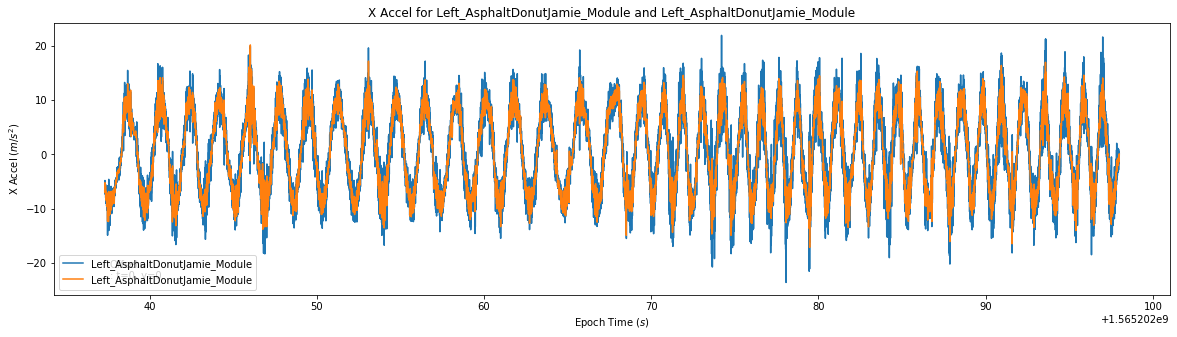

In [27]:
# Again compare filtered and unfiltered data
dataset_compare(np_to_pd(raw_datasets), dataset_labels[0], 
                np_to_pd(datasets), dataset_labels[0], 'X Accel')

### Part (b) - Further Time Domain Visualization

In [28]:
'''Compare Z Gyro of frame to Z Gyro calculated by combining wheel data, for Pandas data'''
def gyro_compare(dataset, label, xlim=None):
    plt.clf()
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Calculate Z Gyro using wheel data
    r_wheel = 0.30
    d_base = 0.54
    calc = (r_wheel / d_base)*(-1 * dataset['Left_' + label]['Z Gyro'] - dataset['Right_' + label]['Z Gyro'])
    calc = np.reshape(calc, dataset['Right_' + label]['Epoch Time'].shape)
    
    # Plot actual frame gyro, calculated frame gyro, and actual wheel gyro
    ax.plot(dataset['Middle_' + label]['Epoch Time'], dataset['Middle_' + label]['Z Gyro'], 
            label='Actual Frame')
    ax.plot(dataset['Right_' + label]['Epoch Time'], calc, label='Calculated Frame')
    ax.plot(dataset['Left_' + label]['Epoch Time'], dataset['Left_' + label]['Z Gyro'], 
            label='Actual L Wheel')
    ax.plot(dataset['Right_' + label]['Epoch Time'], dataset['Right_' + label]['Z Gyro'],
            label='Actual R Wheel')
    
    # Other figure stuff
    ax.set_xlabel('Epoch Time ($s$)')
    ax.set_ylabel('Z Gyro ($m/s^2$)')
    ax.set_title('Comparing Actual to Calculated Z Gyro Data')
    
    if xlim:
        start_time = dataset['Middle_' + label]['Epoch Time'][0]
        ax.set_xlim(xlim[0] + start_time, xlim[1] + start_time)
    ax.legend()
    plt.show()

In [29]:
#gyro_compare(np_to_pd(datasets), 'ConcreteDonutKevin_Module', xlim=(20, 40))

## Part 3 - Time Windows

### Part (a) - Creating Time Windowed Data

In [30]:
datasets_windowed = {}

# Trim excess datapoints, then split into windows
for label, dataset in datasets.items():
    window_size = get_window_size(label)
    n_windows = int(len(dataset) / window_size) # Total windows that fit in the dataset
    n_points = n_windows * window_size # Total number of points that fit in non-overlapping windows
    
    # Windowed data
    dataset_windowed = []
    
    # Iterate through dataset by half a window at a time and extract windows
    i = 0
    window_slide = int(window_size / 2)
    
    while (i < n_points):
        dataset_windowed.append(dataset[i:i + window_size])
        i += window_slide
    
    datasets_windowed.update({label: dataset_windowed})

In [31]:
# Check if its constructed correctly
print('Num windowed datasets: {}'.format(len(datasets_windowed)))
print('Num of windows in first dataset: {}'.format(len(datasets_windowed[dataset_labels[0]])))
print('Shape of individual window: {}'.format(datasets_windowed[dataset_labels[0]][0].shape))

Num windowed datasets: 333
Num of windows in first dataset: 121
Shape of individual window: (333, 8)


In [32]:
# Try out Pandas conversion again
np_to_pd(datasets_windowed, windowed=True)[dataset_labels[0]][0].tail()

,X Accel,Y Accel,Z Accel,X Gyro,Y Gyro,Z Gyro,Run Time,Epoch Time
328,-0.761103,10.857539,0.452852,0.050812,0.467124,3.293363,9.899,1.565202e+09
329,-0.717929,10.717496,1.784095,0.054129,0.471190,3.324165,9.902,1.565202e+09
330,-0.491972,10.458396,1.649796,0.054505,0.472238,3.358083,9.905,1.565202e+09
331,-0.148952,10.471219,0.076395,0.061051,0.475071,3.392778,9.908,1.565202e+09
332,0.113552,10.805944,-1.311798,0.077564,0.484073,3.424948,9.911,1.565202e+09


<Figure size 432x288 with 0 Axes>

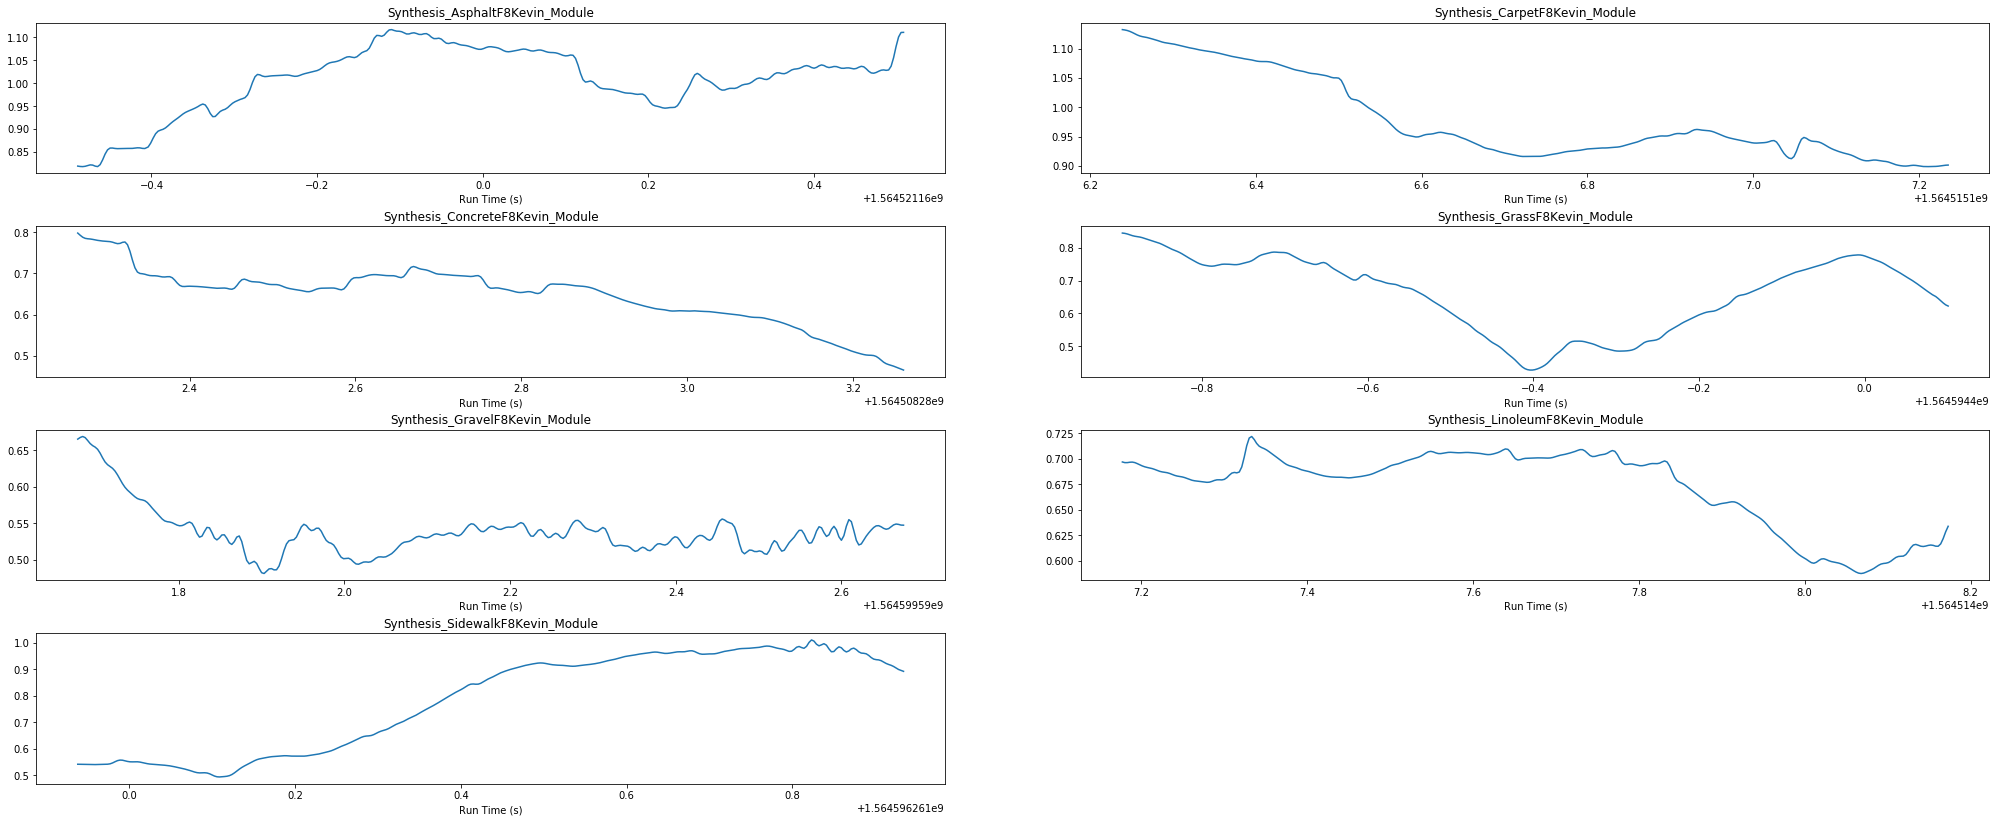

In [33]:
# Plot the first time window
datasets_to_plot = {label: dataset for label, dataset in datasets_windowed.items() if 'Synthesis' in label and 'F8' in label and 'Kevin' in label}
plot_all(np_to_pd(datasets_to_plot, windowed=True), 
         x_axis='Run Time', y_axis='Calc X Vel', windowed=True, win_num=102)

#### Data Structure

`Terrain Dataset Dictionary
-> Data Window List
---> NP Array
-----> Row = Datapoint
-----> Col = Direction | Time`

## Part 4 - Transforms

In [34]:
# Butterworth filter bandpass isn't a perfect edge so there is still some relevant data past the cutoff
N_BINS_OVER_CUTOFF = 5

In [35]:
'''Plot transform of given direction and window of a windowed NumPy dataset dictionary'''
def plot_set_transforms(datasets_transformed, dirn, win_num, transform_name):
    plt.clf()
    plt.figure(figsize=(12, 8))
    
    # Plot all the FFTs in one figure overlaid
    for label, dataset in datasets_transformed.items():
        plt.plot(dataset[win_num][:, -1], dataset[win_num][:, dirn], 
                 label=label)
    plt.legend()

    plt.xlabel('Frequency ($Hz$)')
    if (transform_name == 'FFT'):
        plt.ylabel('Amplitude (Normalized to Window Size)')
    elif (transform_name == 'PSD'):
        plt.ylabel('Amplitude (Log-Scaled)')

    plt.title(transform_name +' of ' + get_columns(label)[dirn] + ', Window {}'.format(win_num))
    plt.show()

### Part (a) - FFT

In [36]:
datasets_fft = {}

# Find the FFT of each column of each data window of each dataset
for label, dataset in datasets_windowed.items():
    dataset_fft = []
    
    for window in dataset:
        # Get relevant parameters for given label
        f_samp, f_low, f_high = get_frequencies(label)        
        n_data_col = get_n_data_col(label)
        
        # Only include frequency bins up to and a little bit past the cutoff frequency
        # Everything past that is useless because its the same on all terrains
        window_size = get_window_size(label)
        n_bins = int(window_size / f_samp * f_low) + N_BINS_OVER_CUTOFF
        window_fft = np.zeros((n_bins, n_data_col))
        
        for i in range(n_data_col):
            # FFT is normalized to window size, to ensure consistency between different size choices
            window_fft[:, i] = np.resize(np.abs(np.divide(np.fft.fft(window[:, i]), window_size)), n_bins)
            
        # Get positive frequency bins for given FFT parameters
        freq_col = np.transpose([np.resize(np.fft.fftfreq(window_size, 1 / f_samp), n_bins)])
        
        # Append the frequency column
        window_fft = np.append(window_fft, freq_col, axis=1)
        dataset_fft.append(window_fft)
        
    datasets_fft.update({label + '_FFT': dataset_fft})

In [37]:
# Check again if its constructed correctly
print('Num of FFT\'d windowed datasets: {}'.format(len(datasets_fft)))
print('Num of FFT\'d windows in first dataset: {}'.format(len(datasets_fft[dataset_labels[4]+'_FFT'])))
print('Shape of FFT\'d individual window: {}'.format(datasets_fft[dataset_labels[4]+'_FFT'][0].shape))

# Test Pandas conversion
np_to_pd(datasets_fft, windowed=True)[dataset_labels[0]+'_FFT'][0].head()

Num of FFT'd windowed datasets: 333
Num of FFT'd windows in first dataset: 348
Shape of FFT'd individual window: (64, 7)


,X Accel,Y Accel,Z Accel,X Gyro,Y Gyro,Z Gyro,Frequency
0,6.333740,4.292461,0.144244,0.533097,0.167732,2.363399,0.000000
1,1.732127,2.682901,0.036650,0.230266,0.130634,0.133853,1.000901
2,0.581895,1.430385,0.111187,0.015819,0.121918,0.033870,2.001802
3,0.262913,1.075483,0.044565,0.068944,0.050837,0.048282,3.002703
4,0.245442,0.887364,0.039754,0.051774,0.029840,0.074794,4.003604


<Figure size 432x288 with 0 Axes>

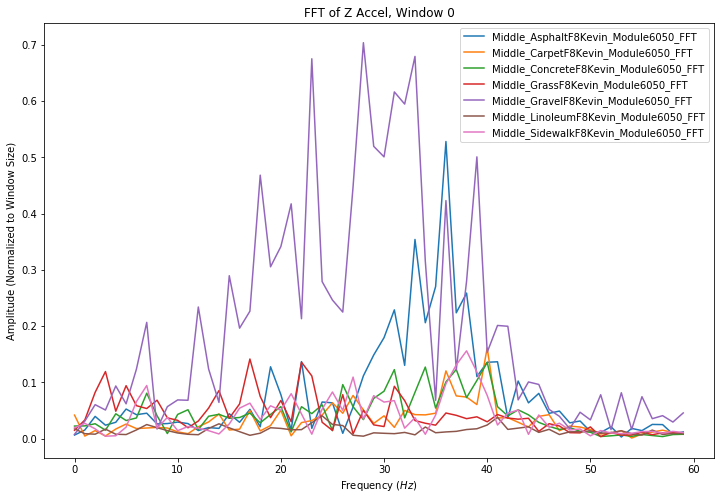

In [38]:
# Compare some FFTs
ffts_to_plot = {label: dataset for label, dataset in datasets_fft.items() if 'Middle' in label and 'F8' in label and 'Kevin' in label}
plot_set_transforms(ffts_to_plot, win_num=0, dirn=2, transform_name='FFT')

**The number of frequency bins is dependent on window size, and it seems to affect amplitude too.**

<Figure size 432x288 with 0 Axes>

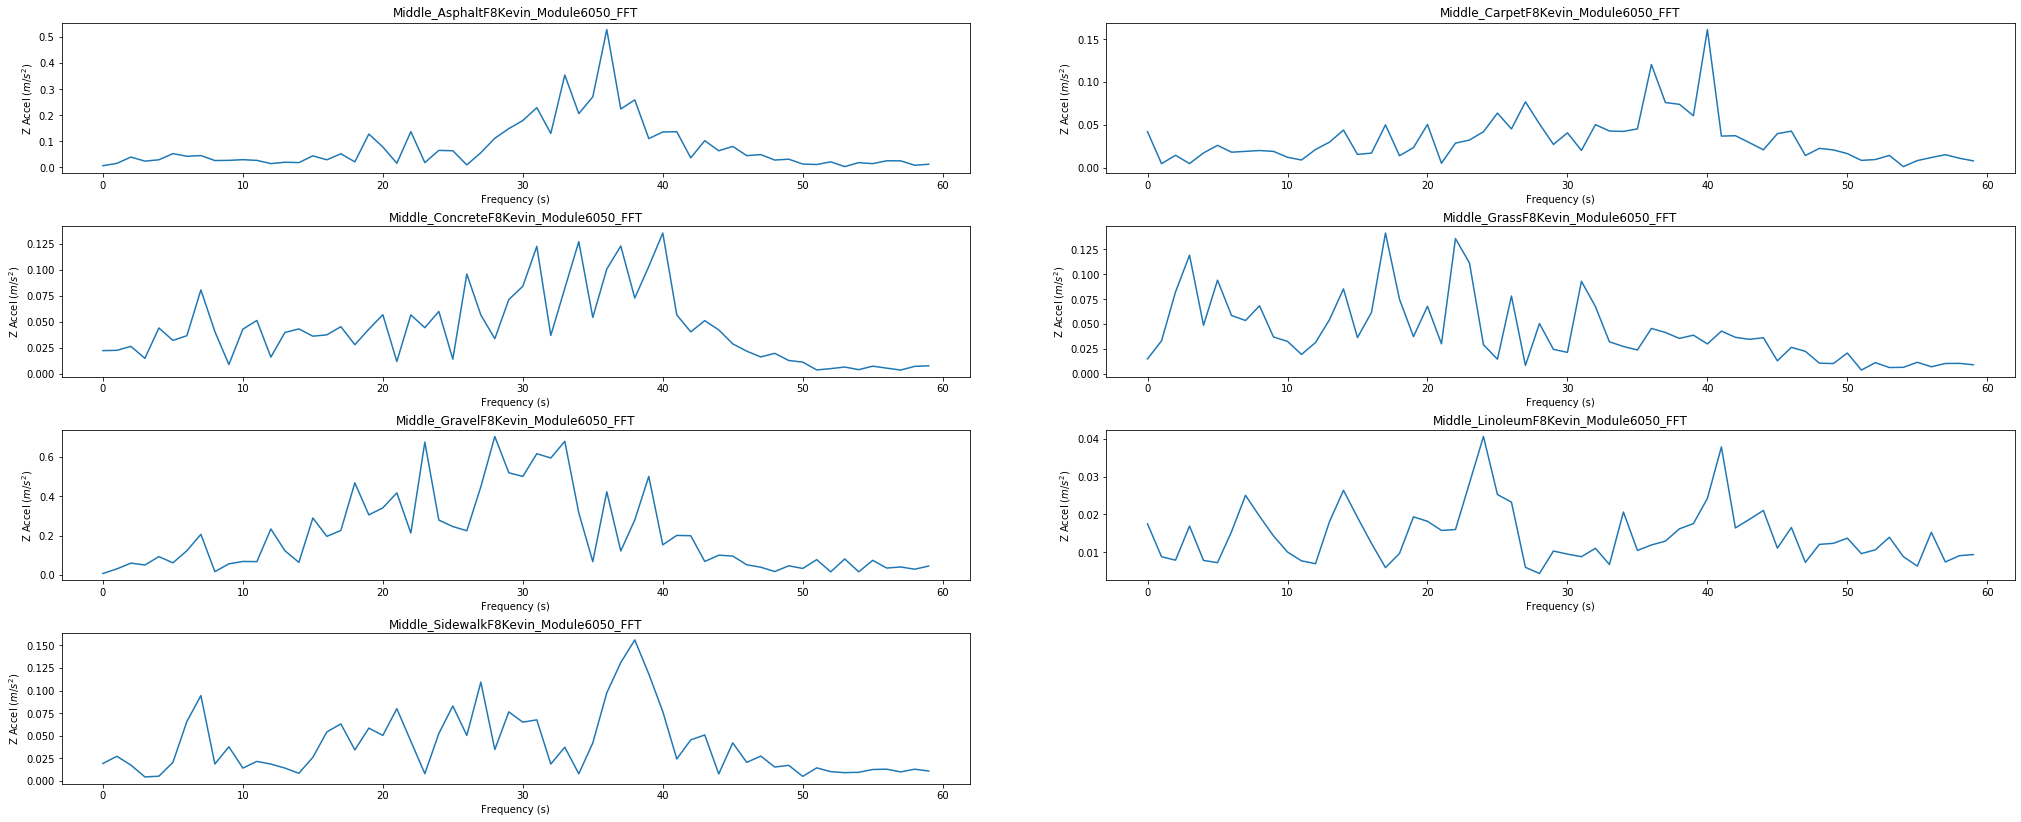

In [39]:
# Compare some FFTs
plot_all(np_to_pd(ffts_to_plot, windowed=True), x_axis='Frequency', y_axis='Z Accel', windowed=True)

### Part (b) - PSD

In [40]:
datasets_psd = {}
datasets_psd_log = {}

# Find the PSD and log(PSD) of each column of each data window of each dataset
for label, dataset in datasets_windowed.items():
    dataset_psd = []
    dataset_psd_log = []
    
    for window in dataset:
        # Frequencies depedent on dataset and device used
        f_samp, f_low, f_high = get_frequencies(label)
        
        # Number of columns of data different for synthesis data
        n_data_col = get_n_data_col(label)
        
        # Only include frequency bins up to and a little bit past the cutoff frequency
        # Everything past that is useless because its the same on all terrains
        window_size = get_window_size(label)
        n_bins = int(window_size / f_samp * f_low) + N_BINS_OVER_CUTOFF
        window_psd = np.zeros((n_bins, n_data_col))
        window_psd_log = np.zeros((n_bins, n_data_col))
        
        # Calculate PSD for each axes
        for i in range(n_data_col):
            # Normalized PSD - Returns frequencies and power density
            freq, Pxx = signal.periodogram(window[:, i], f_samp)
            window_psd[:, i] = np.resize(Pxx[1:], n_bins)
            
            # Calculate log10 of PSD, replacing points where PSD = 0 with 0 to avoid division by 0
            for j in range(len(window_psd[:, i])):
                if (window_psd[j, i] == 0):
                    window_psd_log[j, i] = 0
                else:
                    window_psd_log[j, i] = np.log10(window_psd[j, i])
            
        # Append freq column
        freq_col = np.transpose([np.resize(freq[:-1], n_bins)])
        window_psd = np.append(window_psd, freq_col, axis=1)
        window_psd_log = np.append(window_psd_log, freq_col, axis=1)
        
        dataset_psd.append(window_psd)
        dataset_psd_log.append(window_psd_log)
        
    datasets_psd.update({label + '_PSD': dataset_psd})
    datasets_psd_log.update({label +'_PSDLog': dataset_psd_log})

In [41]:
# Check again if its constructed correctly
print('Num PSD\'d windowed datasets: {}'.format(len(datasets_psd)))
print('Num of PSD\'d windows in first dataset: {}'.format(len(datasets_psd[dataset_labels[0]+'_PSD'])))
print('Shape of PSD\'d individual window: {}'.format(datasets_psd[dataset_labels[0]+'_PSD'][0].shape))

Num PSD'd windowed datasets: 333
Num of PSD'd windows in first dataset: 121
Shape of PSD'd individual window: (64, 7)


<Figure size 432x288 with 0 Axes>

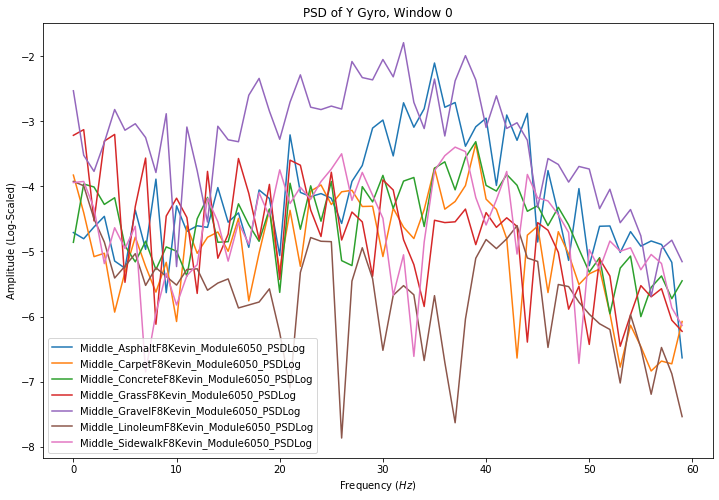

In [42]:
# Compare some Log PSDs
psds_to_plot = {label: dataset for label, dataset in datasets_psd_log.items() if 'Middle' in label and 'F8' in label and 'Kevin' in label}
plot_set_transforms(psds_to_plot, win_num=0, dirn=4, transform_name='PSD')

<Figure size 432x288 with 0 Axes>

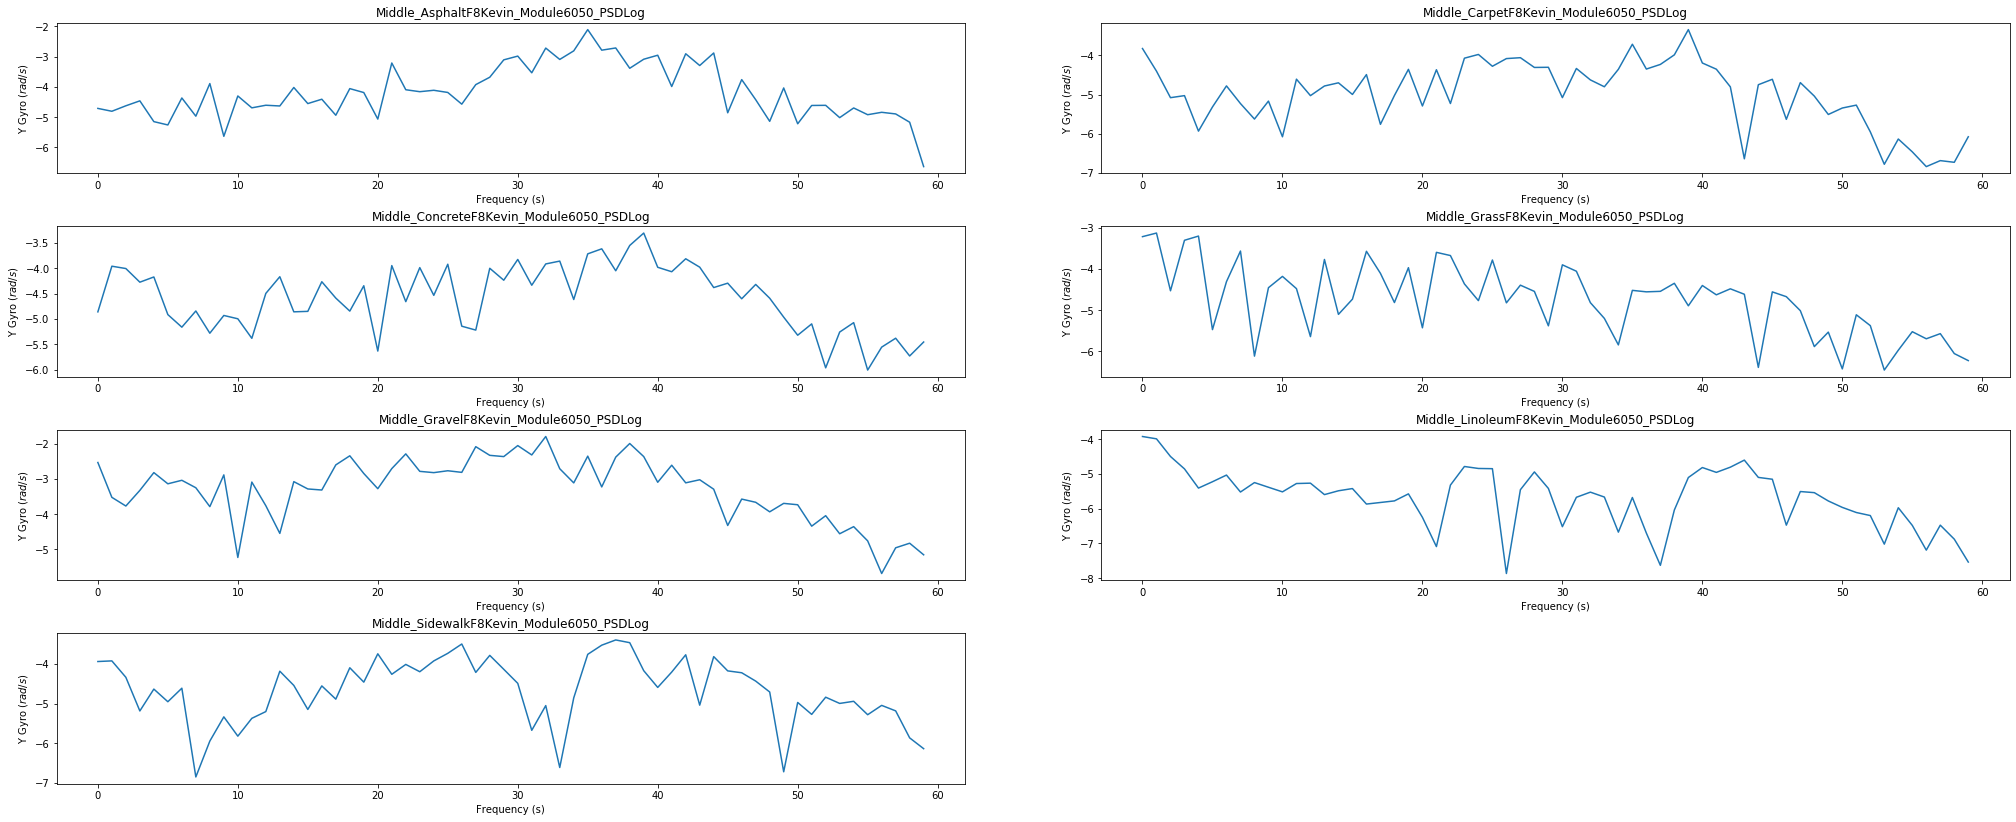

In [43]:
# Compare some Log PSDs
plot_all(np_to_pd(psds_to_plot, windowed=True), x_axis='Frequency', y_axis='Y Gyro', windowed=True)

#### Data Structure:

`Labelled Terrain Dataset
-> Time Window
---> 2D NumPy Array
-----> Row = Transform Value for Frequency
-----> Col = Dirn | Frequency`

### Part (c) - 3D Visualization

In [44]:
'''Plot the set transforms in 3d'''
def plot_transforms_3d(datasets_transformed, win_num, dirn, transform_name):
    plt.clf()
    fig = plt.figure(figsize=(10, 8))
    ax = fig.gca(projection='3d')
    
    # Specific plot parameters for different transforms
    if transform_name == 'FFT':
        z_lim = (0, 1.6)
        ax.set_zlim(z_lim[0], z_lim[1])
        ax.set_zlabel('Amplitude (Normalized to Window Size)')
    elif transform_name == 'PSD':
        z_lim = (-10, -30)
        ax.set_zlim(z_lim[0], z_lim[1])
        ax.set_zlabel('Amplitude (Log-Scaled)')
    
    n_datasets = len(datasets_transformed)
    
    # Change y axis to corespond with terrain labels
    ax.set_ylim(0.5, n_datasets+0.5)
    subset = np.arange(0, n_datasets, dtype=int)
    ax.set_yticks(np.add(subset, 1.5))
    y_labels = [get_terrain_name(get_terrain_num(key)) for key in datasets_transformed.keys()]
    ax.set_yticklabels(y_labels)
    
    ax.set_xlabel('Frequency ($Hz$)')
    
    # Bar graph paremeters
    width = depth = 0.75
    
    # TODO: Sort by max amplitude
    # Plot each dataset FFT
    for i, (label, dataset) in enumerate(datasets_transformed.items()):
        # To plot
        x = dataset[win_num][:, -1]
        y = [i+1]
        top = dataset[win_num][:, dirn]
        
        # Specific to transform
        bot = np.full(top.shape, z_lim[0])
        ax.bar3d(x, y, bot, width, depth, top, alpha=0.8)
        
        # TODO: Make this nicer
        ax.set_title(transform_name + ' of ' + get_columns(label)[dirn] + ', Window {}'.format(win_num))
    
    plt.show()

<Figure size 432x288 with 0 Axes>

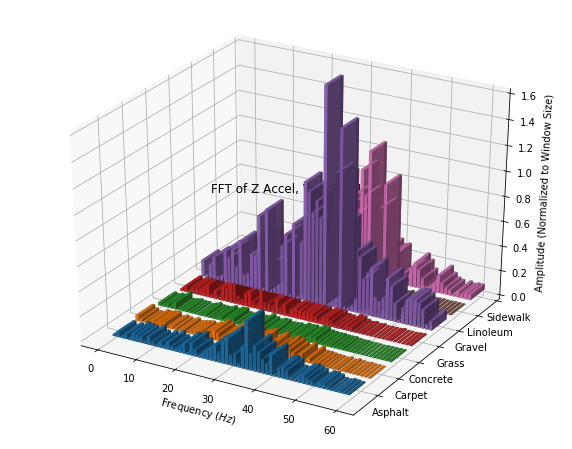

In [45]:
# Compare some FFTs in 3D
ffts_to_plot = {label: dataset for label, dataset in datasets_fft.items() if 'Middle' in label and 'F8' in label and 'Kevin' in label}
plot_transforms_3d(ffts_to_plot, win_num=4, dirn=2, transform_name='FFT')

<Figure size 432x288 with 0 Axes>

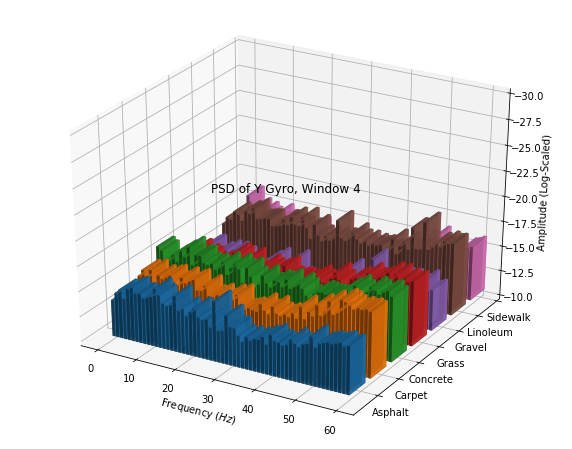

In [46]:
# Compare some PSDs in 3D
psds_to_plot = {label: dataset for label, dataset in datasets_psd_log.items() if 'Middle' in label and 'F8' in label and 'Kevin' in label}
plot_transforms_3d(psds_to_plot, win_num=4, dirn=4, transform_name='PSD')

### Part (d) - Spectograms

In [47]:
'''Plot a spectogram of data'''
def plot_spectogram(set_label, dirn, size):    
    plt.clf()
    plt.figure(figsize=(12, 8))
    
    # Get sampling frequency for label
    f_samp, f_low, f_high = get_frequencies(set_label)
    
    # Compute spectogram directly using time series data
    plt.specgram(datasets[set_label][:, dirn], NFFT=size, Fs=f_samp)
    plt.title('Spectrogram of {} for {}'.format(get_columns(set_label)[dirn], set_label))
    plt.xlabel('Data Window')
    plt.xticks(label=np.arange(0, len(datasets_windowed[set_label])))
    plt.ylabel('Frequency ($Hz$)')
    
    plt.show()

<Figure size 432x288 with 0 Axes>

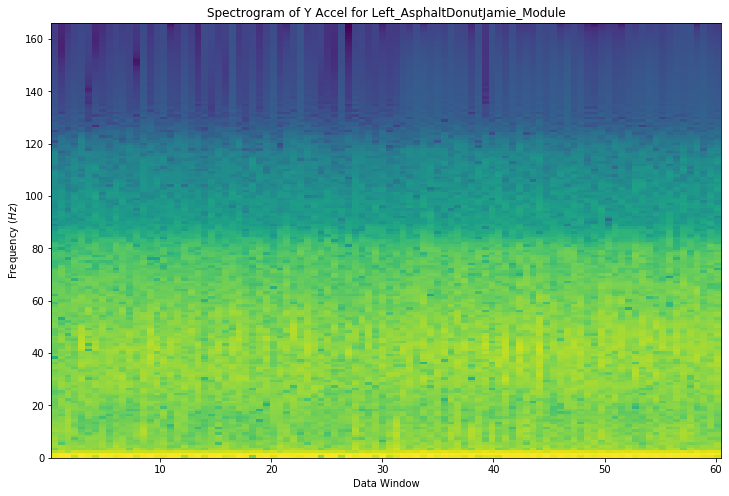

In [48]:
plot_spectogram(dataset_labels[0], dirn=1, size=get_window_size(dataset_labels[0]))

## Part 5 - Feature Extraction

Extract relevant features (e.g. Mean, Min, Skew, ...) from each data window

In [49]:
# Feature extraction functions

# For small float values
EPSILON = 0.00001

'''L2 norm of an array'''
def l2norm(array):
    return np.linalg.norm(array, ord=2)

'''Correlation of an array with itself'''
def autocorr(array):
    return np.correlate(array, array)[0]

'''Root mean squared of an array'''
def rms(array):
    return np.sqrt(np.mean(array ** 2))

'''Zero crossing rate of an array as a fraction of total size of array'''
def zcr(array):
    # Find locations where array > 0, put -1 and 1 for each rising/falling point from 0,
    # divide by total datapoints in window
    return len(np.nonzero(np.diff(array > 0.0))[0]) / len(array)

'''Mean square frequency'''
def msf(freqs, psd_amps):
    num = np.sum(np.multiply(np.resize(freqs, len(psd_amps)), np.power(psd_amps, 2)))
    denom = np.sum(psd_amps)
    
    # In case zero amplitude transform is ecountered
    if denom <= EPSILON:
        return EPSILON
    
    return np.divide(num, denom)

'''Root mean square frequency'''
def rmsf(freqs, psd_amps):
    return np.sqrt(msf(freqs, psd_amps))

'''Frequency center'''
def fc(freqs, psd_amps):
    num = np.sum(np.multiply(np.resize(freqs, len(psd_amps)), psd_amps))
    denom = np.sum(psd_amps)
    
    # In case zero amplitude transform is ecountered
    if denom <= EPSILON:
        return EPSILON
    
    return np.divide(num, denom)

'''Variance frequency'''
def vf(freqs, psd_amps):
    return msf(freqs, psd_amps) - fc(freqs, psd_amps) ** 2

'''Root variance frequency'''
def rvf(freqs, psd_amps):
    return np.sqrt(msf(freqs, psd_amps))

In [50]:
'''Extract given features from column of each dataset
   Converts a dictionary of datasets to a nested dictionary where each dataset has its own dictionary
   of axes/directions'''
def feature_all(features, datasets, regular=True):
    datasets_feat = {}
    
    # Calculate features for each window of each column of each dataset
    for label, dataset in datasets.items():
        directions = {}
        n_data_col = get_n_data_col(label)
        
        # Loop over data columns
        for i, direction in enumerate(get_columns(label)[:n_data_col]):
            feats = {}
            
            if (regular):
                '''Execute a function over all windows'''
                def function_all_windows(function):
                    feat_in_window = []
                    
                    for window in dataset:
                        feat_in_window.append(function(window[:, i]))
                    
                    return feat_in_window        
            else:
                '''Alternate defintion for frequency functions'''
                def function_all_windows(function):
                    feat_in_window = []
                    
                    for window in dataset:
                        feat_in_window.append(function(window[:, -1], window[:, i]))
                    
                    return feat_in_window
                    
            # Execute every function over all windows    
            for feat_name, feat_func in features.items():
                feats.update({feat_name: function_all_windows(feat_func)})
            
            directions.update({direction: pd.DataFrame.from_dict(feats)})

        datasets_feat.update({label.replace('_PSD', ''): directions})
    
    return datasets_feat

In [51]:
'''Plot a feature on all terrains for each time window'''
def plot_set_features(datasets_feat, dirn, feat_name, placement_name, ylim=None, xlim=None):
    plt.clf()
    plt.figure(figsize=(10,8))
    
    for label, dataset in datasets_feat.items():
        plt.plot(dataset[dirn][feat_name], label=label)
    
    # Set limits if they've been given
    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])
    if xlim is not None:
        plt.xlim(xlim[0], xlim[1])
    
    plt.ylabel(feat_name)
    plt.xlabel('Window #')
    plt.title(placement_name + ' ' + dirn)
    plt.legend()
    plt.show()

### Part (a) - Time Domain Features

In [52]:
# Time domain feature functions and names
time_features = {'Mean': np.mean, 'Std': np.std,  'Norm': l2norm, 'AC': autocorr, 
                 'Max': np.amax, 'Min' : np.amin, 'RMS': rms, 'ZCR': zcr, 
                 'Skew': stats.skew, 'EK': stats.kurtosis} 

# Create array of features of each window for each dataset and direction
datasets_feat_time = feature_all(time_features, datasets_windowed)

In [53]:
# Check if feature data is constructed correctly and print some info
print('Num datasets: {}'.format(len(datasets_feat_time)))
print('Num directions: {}'.format(len(datasets_feat_time[dataset_labels[0]])))
print('Shape of first dataset first direction: {}'.format(datasets_feat_time[dataset_labels[0]]['X Accel'].shape))

Num datasets: 333
Num directions: 6
Shape of first dataset first direction: (121, 10)


<Figure size 432x288 with 0 Axes>

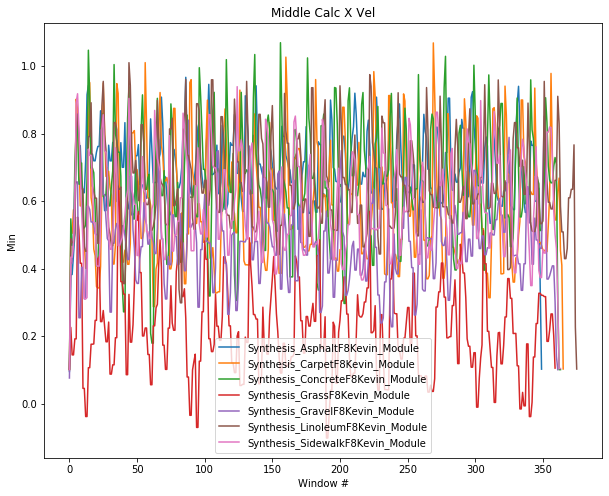

In [56]:
# Plot some time feature data
feat_datasets_to_plot = {label: dataset for label, dataset in datasets_feat_time.items() if 'Synthesis' in label and 'F8' in label and 'Kevin' in label}
plot_set_features(feat_datasets_to_plot, dirn='Calc X Vel', feat_name='Min', placement_name='Middle')

### Part (b) - Frequency Domain Features

In [57]:
# Frequency domain feature functions and names
freq_features = {'MSF': msf, 'RMSF': rmsf, 'FC': fc, 'VF': vf, 'RVF': rvf}

# Create array of features of each window for each dataset and direction
datasets_feat_freq = feature_all(freq_features, datasets_psd, regular=False)

In [58]:
# Check if feature data is constructed correctly and print some info
print('Num datasets: {}'.format(len(datasets_feat_freq)))
print('Num directions: {}'.format(len(datasets_feat_freq[dataset_labels[0]])))
print('Shape of one direction: {}'.format(datasets_feat_freq[dataset_labels[0]]['X Accel'].shape))

Num datasets: 333
Num directions: 6
Shape of one direction: (121, 5)


<Figure size 432x288 with 0 Axes>

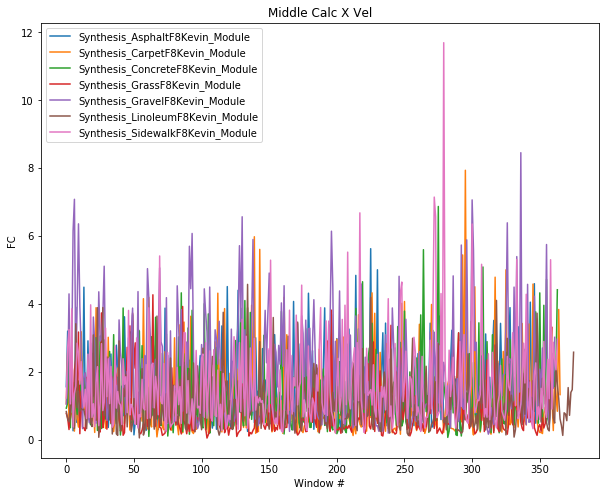

In [59]:
# Plot some frequency feature data
feat_datasets_to_plot = {label: feature for label, feature in datasets_feat_freq.items() if 'Synthesis' in label and 'F8' in label and 'Kevin' in label}
plot_set_features(feat_datasets_to_plot, dirn='Calc X Vel', feat_name='FC', placement_name='Middle')

#### Data Structure

`Terrain Dataset Dictionary
-> Direction Dictionary 
---> Pandas Array
-----> Row = Window #
-----> Col = Extracted Feature`

## Part 6 - Columning, Combination, and Standardization of Datasets

In [60]:
# Convert transform data to Pandas
datasets_fft = np_to_pd(datasets_fft, windowed=True)
datasets_psd_log = np_to_pd(datasets_psd_log, windowed=True)

### Part (a) - Columning Data

Combine IMU data from each direction into single dataframes with columns for each feature in each direction

In [61]:
'''Append a tag to the end of every column name of a dataframe'''
def append_all_columns(columns, append_tag):
    new_columns = []
    
    for column in columns:
        new_columns.append(column + ' ' + append_tag)
    
    return new_columns

#### Part (i) - Extracted Featured Data

In [62]:
'''Combined directions (axes) of a featured dataset'''
def combine_extracted_columns(datasets):
    datasets_combined = {}
    
    for label, dataset in datasets.items():
        # Get labels array of first column
        df_combined = pd.DataFrame()
        
        # Append direction name to feature name and combine everything in one frame
        for dirn_label, dirn_df in dataset.items():
            df_copy = pd.DataFrame(dirn_df)
            
            # Add direction and placement tags
            df_copy.columns = append_all_columns(dirn_df.columns, dirn_label)
            df_copy.columns = append_all_columns(dirn_df.columns, get_placement(label))
            
            df_combined = df_combined.join(dirn_df, how='outer')
        
        datasets_combined.update({label: df_combined})
    
    return datasets_combined

In [63]:
# Take time feature data and combine axes columns
datasets_feat_time_columned = combine_extracted_columns(datasets_feat_time)

# Confirm formatting
datasets_feat_time_columned[dataset_labels[0]].head()

,Mean X Accel Left,Std X Accel Left,Norm X Accel Left,AC X Accel Left,Max X Accel Left,Min X Accel Left,RMS X Accel Left,ZCR X Accel Left,Skew X Accel Left,EK X Accel Left,...,Mean Z Gyro Left,Std Z Gyro Left,Norm Z Gyro Left,AC Z Gyro Left,Max Z Gyro Left,Min Z Gyro Left,RMS Z Gyro Left,ZCR Z Gyro Left,Skew Z Gyro Left,EK Z Gyro Left
0,-6.333740,2.799001,126.362857,15967.571542,0.113552,-12.370650,6.924642,0.003003,0.325974,-0.815695,...,2.363399,0.281730,43.433334,1886.454489,3.424948,1.892358,2.380132,0.0,1.507718,2.057499
1,1.653583,6.497414,122.346200,14968.592540,12.992936,-9.038265,6.704530,0.009009,0.106563,-1.529988,...,3.104408,0.778312,58.403404,3410.957655,4.013827,2.036325,3.200487,0.0,-0.165735,-1.796213
2,5.929635,3.250590,123.397976,15227.060494,12.992936,-1.152094,6.762167,0.015015,-0.069202,-0.881793,...,3.291342,0.592222,61.025885,3724.158656,4.013827,2.376084,3.344198,0.0,-0.248861,-1.567967
3,-1.456939,6.265167,117.379173,13777.870183,11.813090,-12.142184,6.432339,0.009009,0.034055,-1.475442,...,2.957739,0.302455,54.255129,2943.619063,3.417796,2.376084,2.973163,0.0,-0.733669,-0.903730
4,-5.760124,3.414559,122.193023,14931.134824,3.935042,-12.142184,6.696136,0.003003,0.894977,0.384612,...,3.212854,0.255178,58.813707,3459.052107,3.844641,2.860065,3.222971,0.0,1.060128,0.443970


In [64]:
# Take frequency feature data and axes columns
datasets_feat_freq_columned = combine_extracted_columns(datasets_feat_freq)

# Confirm formatting
datasets_feat_freq_columned[dataset_labels[0]].head()

,MSF X Accel Left,RMSF X Accel Left,FC X Accel Left,VF X Accel Left,RVF X Accel Left,MSF Y Accel Left,RMSF Y Accel Left,FC Y Accel Left,VF Y Accel Left,RVF Y Accel Left,...,MSF Y Gyro Left,RMSF Y Gyro Left,FC Y Gyro Left,VF Y Gyro Left,RVF Y Gyro Left,MSF Z Gyro Left,RMSF Z Gyro Left,FC Z Gyro Left,VF Z Gyro Left,RVF Z Gyro Left
0,0.169172,0.411305,3.354634,-11.084398,0.411305,1.605854,1.267223,2.487540,-4.582003,1.267223,...,0.012356,0.111157,2.376181,-5.633881,0.111157,0.008964,0.094677,4.493900,-20.186172,0.094677
1,0.757407,0.870292,1.310311,-0.959508,0.870292,0.461036,0.678996,2.453647,-5.559350,0.678996,...,0.002195,0.046852,2.163848,-4.680043,0.046852,0.006717,0.081955,0.613786,-0.370016,0.081955
2,0.247530,0.497524,3.280576,-10.514647,0.497524,1.143088,1.069153,1.747096,-1.909257,1.069153,...,0.013516,0.116258,1.311390,-1.706229,0.116258,0.001408,0.037523,0.201643,-0.039252,0.037523
3,0.767147,0.875869,1.875692,-2.751076,0.875869,0.518083,0.719780,3.657817,-12.861541,0.719780,...,0.000738,0.027169,0.581263,-0.337129,0.027169,0.006834,0.082666,0.675241,-0.449117,0.082666
4,0.270925,0.520504,3.098056,-9.327024,0.520504,1.428883,1.195359,2.892195,-6.935911,1.195359,...,0.016061,0.126731,1.398470,-1.939657,0.126731,0.007947,0.089145,1.105274,-1.213684,0.089145


#### Part (ii) - Transformed Data

In [65]:
'''Combined direction (axes) columns for transformed data'''
def combine_transform_columns(datasets):
    combined_datasets = {}
    
    for label, dataset in datasets.items():
        # Get frequency bins from frequency column of first window
        freq_bins = dataset[0]['Frequency'].tolist()
        
        # Get more parameter for current label
        data_cols = get_columns(label)[:get_n_data_col(label)]
        trans = get_transform(label)
        place = get_placement(label)
        
        # Combine parameters to form columns for new combined DataFrame
        new_cols = [trans + ' {} Hz '.format(round(f_bin)) + d_col + ' ' + place for d_col in data_cols for f_bin in freq_bins]
        
        # Convert windowed arrays into a single array with each window as a row
        new_data = []
        
        for window in dataset:
            new_row = []
            for d_col in data_cols:
                new_row.extend(window[d_col].tolist())
            new_data.append(new_row)
            
        # Create new DataFrame
        combined_df = pd.DataFrame(data=new_data, columns=new_cols)
        combined_datasets.update({label: combined_df})

    return combined_datasets

In [66]:
datasets_fft_columned = combine_transform_columns(datasets_fft)

# Confirm FFT formatting
datasets_fft_columned[dataset_labels[0] + '_FFT'].head()

,FFT 0 Hz X Accel Left,FFT 1 Hz X Accel Left,FFT 2 Hz X Accel Left,FFT 3 Hz X Accel Left,FFT 4 Hz X Accel Left,FFT 5 Hz X Accel Left,FFT 6 Hz X Accel Left,FFT 7 Hz X Accel Left,FFT 8 Hz X Accel Left,FFT 9 Hz X Accel Left,...,FFT 54 Hz Z Gyro Left,FFT 55 Hz Z Gyro Left,FFT 56 Hz Z Gyro Left,FFT 57 Hz Z Gyro Left,FFT 58 Hz Z Gyro Left,FFT 59 Hz Z Gyro Left,FFT 60 Hz Z Gyro Left,FFT 61 Hz Z Gyro Left,FFT 62 Hz Z Gyro Left,FFT 63 Hz Z Gyro Left
0,6.333740,1.732127,0.581895,0.262913,0.245442,0.147013,0.223646,0.108940,0.104232,0.073182,...,0.004815,0.004540,0.004504,0.004483,0.004714,0.004652,0.004582,0.004111,0.004302,0.004248
1,1.653583,4.014842,1.357264,1.078955,0.759555,0.455978,0.426564,0.376261,0.291122,0.178050,...,0.003759,0.003852,0.003579,0.004279,0.004114,0.003273,0.003892,0.003788,0.003288,0.003577
2,5.929635,1.990953,0.640682,0.354558,0.386178,0.066885,0.170908,0.035940,0.186178,0.146739,...,0.000495,0.000436,0.000524,0.000794,0.000295,0.000312,0.000459,0.000958,0.000455,0.000722
3,1.456939,3.844008,1.020029,1.187549,0.605093,0.557674,0.510419,0.465749,0.416782,0.295452,...,0.001065,0.001395,0.001303,0.001294,0.000791,0.000923,0.001271,0.001004,0.001046,0.001164
4,5.760124,2.090174,0.652781,0.502922,0.382440,0.229552,0.273769,0.245209,0.104051,0.070917,...,0.002515,0.001821,0.001667,0.001577,0.002148,0.000987,0.002041,0.001354,0.001884,0.001161


In [67]:
datasets_psd_log_columned = combine_transform_columns(datasets_psd_log)

# Check PSD formatting
datasets_psd_log_columned[dataset_labels[0] + '_PSDLog'].head()

,PSDLog 0 Hz X Accel Left,PSDLog 1 Hz X Accel Left,PSDLog 2 Hz X Accel Left,PSDLog 3 Hz X Accel Left,PSDLog 4 Hz X Accel Left,PSDLog 5 Hz X Accel Left,PSDLog 6 Hz X Accel Left,PSDLog 7 Hz X Accel Left,PSDLog 8 Hz X Accel Left,PSDLog 9 Hz X Accel Left,...,PSDLog 54 Hz Z Gyro Left,PSDLog 55 Hz Z Gyro Left,PSDLog 56 Hz Z Gyro Left,PSDLog 57 Hz Z Gyro Left,PSDLog 58 Hz Z Gyro Left,PSDLog 59 Hz Z Gyro Left,PSDLog 60 Hz Z Gyro Left,PSDLog 61 Hz Z Gyro Left,PSDLog 62 Hz Z Gyro Left,PSDLog 63 Hz Z Gyro Left
0,0.777799,-0.169672,-0.859738,-0.919463,-1.364651,-1.000238,-1.624990,-1.663359,-1.970555,-2.288169,...,-4.385332,-4.392160,-4.396285,-4.352626,-4.364150,-4.377318,-4.471361,-4.431971,-4.442994,-4.491891
1,1.507976,0.565967,0.366646,0.061757,-0.381473,-0.439393,-0.548382,-0.771211,-1.198278,-0.807995,...,-4.527920,-4.591953,-4.436583,-4.470751,-4.669533,-4.518950,-4.542640,-4.665597,-4.592268,-4.562879
2,0.898761,-0.086076,-0.599987,-0.525787,-2.048708,-1.233836,-2.588204,-1.159505,-1.366272,-2.080084,...,-6.420829,-6.260631,-5.900026,-6.760885,-6.709691,-6.376625,-5.736945,-6.383205,-5.981847,-6.725347
3,1.470207,0.317864,0.449942,-0.135716,-0.206600,-0.283508,-0.363057,-0.459544,-0.758388,-0.706590,...,-5.410167,-5.469548,-5.475496,-5.903345,-5.769367,-5.491395,-5.695793,-5.660379,-5.567280,-5.275124
4,0.941004,-0.069826,-0.296359,-0.534234,-0.977599,-0.824594,-0.920290,-1.664872,-1.997857,-1.883839,...,-5.178554,-5.255735,-5.303902,-5.035121,-5.710362,-5.079518,-5.436115,-5.149359,-5.569672,-5.490752


### Part (b) - Adding Labels

Create a new column containg the an integer label for each terrain.

In [68]:
'Add labels to a dataset'
def insert_labels(datasets):
    # Returns new datasets
    datasets_copy = {}
    
    # Add to each dataframe of a dataset
    for label, dataset in datasets.items():
        terrain_num = get_terrain_num(label)
        labels = [terrain_num for _ in range(len(dataset))]
        
        dataset_copy = dataset.copy()
        dataset_copy.insert(0, 'Label', labels)
        
        datasets_copy.update({label: dataset_copy})
    
    return datasets_copy

In [69]:
# Add labels to each of the feature vector types
datasets_feat_time_columned = insert_labels(datasets_feat_time_columned)
datasets_feat_freq_columned = insert_labels(datasets_feat_freq_columned)
datasets_fft_columned = insert_labels(datasets_fft_columned)
datasets_psd_log_columned = insert_labels(datasets_psd_log_columned)

In [70]:
# Check labelled data
datasets_feat_time_columned[dataset_labels[0]].head()

,Label,Mean X Accel Left,Std X Accel Left,Norm X Accel Left,AC X Accel Left,Max X Accel Left,Min X Accel Left,RMS X Accel Left,ZCR X Accel Left,Skew X Accel Left,...,Mean Z Gyro Left,Std Z Gyro Left,Norm Z Gyro Left,AC Z Gyro Left,Max Z Gyro Left,Min Z Gyro Left,RMS Z Gyro Left,ZCR Z Gyro Left,Skew Z Gyro Left,EK Z Gyro Left
0,3,-6.333740,2.799001,126.362857,15967.571542,0.113552,-12.370650,6.924642,0.003003,0.325974,...,2.363399,0.281730,43.433334,1886.454489,3.424948,1.892358,2.380132,0.0,1.507718,2.057499
1,3,1.653583,6.497414,122.346200,14968.592540,12.992936,-9.038265,6.704530,0.009009,0.106563,...,3.104408,0.778312,58.403404,3410.957655,4.013827,2.036325,3.200487,0.0,-0.165735,-1.796213
2,3,5.929635,3.250590,123.397976,15227.060494,12.992936,-1.152094,6.762167,0.015015,-0.069202,...,3.291342,0.592222,61.025885,3724.158656,4.013827,2.376084,3.344198,0.0,-0.248861,-1.567967
3,3,-1.456939,6.265167,117.379173,13777.870183,11.813090,-12.142184,6.432339,0.009009,0.034055,...,2.957739,0.302455,54.255129,2943.619063,3.417796,2.376084,2.973163,0.0,-0.733669,-0.903730
4,3,-5.760124,3.414559,122.193023,14931.134824,3.935042,-12.142184,6.696136,0.003003,0.894977,...,3.212854,0.255178,58.813707,3459.052107,3.844641,2.860065,3.222971,0.0,1.060128,0.443970


### Part (c) - Combining Datasets

Convert data from each dataset into rows of a single dataframe

In [71]:
'''Combine data from labelled datasets into a single dataframe'''
def combine_datasets(datasets):
    return pd.concat(list(datasets.values()), ignore_index=True)

In [72]:
'''Separate data according to placement, then combine data for each placement and return
   as a dictionary of placements'''
def separate_and_combine(datasets_columned):
    datasets_separated = {}
    
    # Separate according to mounting location
    for placement in placements:
        datasets = {label: dataset for label, dataset in datasets_columned.items() if placement in label}
        
        # Update if not empty
        if bool(datasets): 
            datasets_separated.update({placement: datasets})
    
    # Combine each mounting into a single combined dataframe and drop NaN values, export to csv
    for placement, datasets in datasets_separated.items():
        # TODO: Figure out where NaNs come from
        # Seems to be Calc X Accel
        datasets_separated.update({placement: combine_datasets(datasets).dropna(axis='columns')})
                        
    # Return dictionary of each mounting location
    return datasets_separated

In [73]:
# For each feature vector, combine datasets in two single dataframes
time_feats_unnorm = separate_and_combine(datasets_feat_time_columned)
freq_feats_unnorm = separate_and_combine(datasets_feat_freq_columned)                                      
ffts_unnorm = separate_and_combine(datasets_fft_columned)
psd_logs_unnorm = separate_and_combine(datasets_psd_log_columned)

In [74]:
# Check unnormalized data
time_feats_unnorm['Synthesis'].tail()

,Label,Mean Calc X Vel Synthesis,Std Calc X Vel Synthesis,Norm Calc X Vel Synthesis,AC Calc X Vel Synthesis,Max Calc X Vel Synthesis,Min Calc X Vel Synthesis,RMS Calc X Vel Synthesis,ZCR Calc X Vel Synthesis,Skew Calc X Vel Synthesis,...,Mean Right Z Gyro Synthesis,Std Right Z Gyro Synthesis,Norm Right Z Gyro Synthesis,AC Right Z Gyro Synthesis,Max Right Z Gyro Synthesis,Min Right Z Gyro Synthesis,RMS Right Z Gyro Synthesis,ZCR Right Z Gyro Synthesis,Skew Right Z Gyro Synthesis,EK Right Z Gyro Synthesis
17889,4,0.530042,0.175921,10.191192,103.860386,0.931342,0.332122,0.558474,0.0,0.568776,...,-2.453594,0.821797,47.218567,2229.593046,-0.663028,-3.297234,2.587562,0.000000,0.840513,-0.729499
17890,4,0.834161,0.179004,15.568548,242.379679,1.056929,0.478658,0.853151,0.0,-0.547179,...,-1.108574,0.877367,25.798649,665.570296,-0.205467,-3.097448,1.413757,0.000000,-0.808525,-0.795678
17891,4,0.782959,0.257281,15.039276,226.179828,1.056929,0.227937,0.824147,0.0,-0.792044,...,-0.282726,0.132880,5.700679,32.497742,-0.130712,-0.663028,0.312395,0.000000,-0.690565,-0.637342
17892,4,0.362019,0.267244,8.186563,67.019806,0.927626,0.102267,0.449974,0.0,0.795127,...,-0.101226,0.081018,2.358882,5.564326,0.058974,-0.205467,0.129656,0.003021,0.677689,-0.784486
17893,4,0.142363,0.027048,1.861405,3.464830,0.227937,0.102267,0.144910,0.0,1.257131,...,-0.033058,0.059509,0.874437,0.764640,0.058974,-0.130712,0.068075,0.006061,0.321052,-1.285891


### Part (d) - Standardization (aka Normalization)

Standardize each feature to mean 0 and standard deviation 1. This makes feature selection and classification easier.

In [75]:
'''Normalize combined datasets
   Returns normalized combined datasets, and the parameters (mean, standard dev) used for normalization
   of each feature vector column'''
def normalize_datasets(placements):
    # Object to keep track of scaling parameters
    from sklearn.preprocessing import StandardScaler
    
    placements_norm = {}
    placements_norm_parameters = {}
    
    # Go through combined data
    for placement_name, placement_combined_data in placements.items():
        combined_data = placement_combined_data.copy()
        
        # Pop labels and add back in later, also keep track of columns
        df_labels = combined_data.pop('Label').astype('int32')
        df_cols = combined_data.columns
        scaler = StandardScaler().fit(combined_data)
        
        # Keep track of mean and std deviation (scale_) of scaler for each column as a dictionary
        placement_columns = {}
        for i, df_col in enumerate(df_cols):
            placement_columns.update({df_col: {'Mean': scaler.mean_[i], 'Scale': scaler.scale_[i]}})
            
        placements_norm_parameters.update({placement_name: placement_columns})
        
        # Normalize each combined feature and update placement dictionary
        # Scaler converts to numpy so convert back to DataFrame
        norm_combined_data = scaler.transform(combined_data)
        norm_df = pd.DataFrame(data=norm_combined_data, columns=df_cols)
        norm_df = norm_df.dropna(axis='rows')
        norm_df.insert(0, 'Label', df_labels)
        placements_norm.update({placement_name: norm_df})
        
    return placements_norm, placements_norm_parameters

In [76]:
time_feats, time_feat_params = normalize_datasets(time_feats_unnorm)
freq_feats, freq_feat_params = normalize_datasets(freq_feats_unnorm)
ffts, fft_params = normalize_datasets(ffts_unnorm)
psd_logs, psd_log_params = normalize_datasets(psd_logs_unnorm)

In [77]:
# Check combined and normalized extracted time feature vectors
print('Time Feat Param Dictionary: {}'.format(time_feat_params['Synthesis']['Mean Calc X Vel Synthesis']))
time_feats['Synthesis'].tail()

Time Feat Param Dictionary: {'Mean': 0.8218246243695703, 'Scale': 0.36750306572134017}


,Label,Mean Calc X Vel Synthesis,Std Calc X Vel Synthesis,Norm Calc X Vel Synthesis,AC Calc X Vel Synthesis,Max Calc X Vel Synthesis,Min Calc X Vel Synthesis,RMS Calc X Vel Synthesis,ZCR Calc X Vel Synthesis,Skew Calc X Vel Synthesis,...,Mean Right Z Gyro Synthesis,Std Right Z Gyro Synthesis,Norm Right Z Gyro Synthesis,AC Right Z Gyro Synthesis,Max Right Z Gyro Synthesis,Min Right Z Gyro Synthesis,RMS Right Z Gyro Synthesis,ZCR Right Z Gyro Synthesis,Skew Right Z Gyro Synthesis,EK Right Z Gyro Synthesis
17889,4,-0.793959,1.065550,-0.775904,-0.722220,-0.172572,-0.817171,-0.777825,-0.153511,1.123875,...,0.207535,1.483725,-0.200149,-0.379220,0.862878,0.109928,-0.200939,-0.241527,1.272503,0.062977
17890,4,0.033568,1.112526,0.049535,-0.137233,0.166666,-0.425848,0.048307,-0.153511,-0.798948,...,1.112001,1.692335,-1.052874,-0.903606,1.158841,0.247326,-1.054312,-0.241527,-1.619890,-0.017491
17891,4,-0.105755,2.305017,-0.031710,-0.205648,0.166666,-1.095395,-0.033006,-0.153511,-1.220858,...,1.667348,-1.102451,-1.852972,-1.115862,1.207194,1.921536,-1.855018,-0.241527,-1.412989,0.175031
17892,4,-1.251162,2.456792,-1.083621,-0.877803,-0.182611,-1.430997,-1.082005,-0.153511,1.513885,...,1.789398,-1.297140,-1.986009,-1.124893,1.329888,2.236212,-1.987873,1.446270,0.986911,-0.003882
17893,4,-1.848859,-1.202419,-2.054550,-1.146205,-2.072623,-1.430997,-1.937256,-0.153511,2.309932,...,1.835238,-1.377883,-2.045105,-1.126502,1.329888,2.287622,-2.032643,3.144297,0.361373,-0.613544


In [78]:
# Check combined and normalized extracted time feature vectors
print('Freq Feat Param Dictionary: {}'.format(freq_feat_params['Synthesis']['FC Calc X Vel Synthesis']))
freq_feats['Synthesis'].tail()

Freq Feat Param Dictionary: {'Mean': 1.2325943311129333, 'Scale': 1.064294555786874}


,Label,MSF Calc X Vel Synthesis,RMSF Calc X Vel Synthesis,FC Calc X Vel Synthesis,VF Calc X Vel Synthesis,RVF Calc X Vel Synthesis,MSF Calc Z Gyro Synthesis,RMSF Calc Z Gyro Synthesis,FC Calc Z Gyro Synthesis,VF Calc Z Gyro Synthesis,...,MSF Right Y Gyro Synthesis,RMSF Right Y Gyro Synthesis,FC Right Y Gyro Synthesis,VF Right Y Gyro Synthesis,RVF Right Y Gyro Synthesis,MSF Right Z Gyro Synthesis,RMSF Right Z Gyro Synthesis,FC Right Z Gyro Synthesis,VF Right Z Gyro Synthesis,RVF Right Z Gyro Synthesis
17889,4,0.251736,0.752670,0.638601,-0.175842,0.752670,0.034254,0.362986,-0.549141,0.278702,...,-0.409220,-0.299738,0.240563,0.093180,-0.299738,0.243463,0.820602,0.546014,-0.139800,0.820602
17890,4,0.220643,0.710521,-0.007841,0.201943,0.710521,2.812863,3.004751,0.749604,-0.185105,...,-0.693879,-1.190400,-0.188289,0.206236,-1.190400,0.491360,1.187247,0.668721,-0.236576,1.187247
17891,4,0.919121,1.499430,0.084074,0.158481,1.499430,-0.325120,-0.368955,0.778081,-0.202424,...,-0.696943,-1.218960,0.729719,-0.109565,-1.218960,-0.333098,-0.707587,1.436483,-1.007605,-0.707587
17892,4,1.362057,1.895044,0.362036,0.006307,1.895044,-0.473499,-0.895514,1.795673,-0.903287,...,-0.701938,-1.276061,0.440919,0.019606,-1.276061,-0.356443,-0.943096,0.561534,-0.156148,-0.943096
17893,4,-0.349921,-0.415568,6.139351,-10.096285,-0.415568,-0.526431,-1.328219,0.273529,0.038044,...,-0.706716,-1.364945,-0.088159,0.185229,-1.364945,-0.356718,-0.947578,2.619464,-2.688712,-0.947578


#### Note: More rows of exracted feature data are lost than transform features

In [79]:
# Check combined and normalized extracted time feature vectors
print('FFT Parameter Dictionary: {}'.format(fft_params['Synthesis']['FFT 0 Hz Calc X Vel Synthesis']))
ffts['Synthesis'].tail()

FFT Parameter Dictionary: {'Mean': 0.8223731897897575, 'Scale': 0.3651980759209566}


,Label,FFT 0 Hz Calc X Vel Synthesis,FFT 1 Hz Calc X Vel Synthesis,FFT 2 Hz Calc X Vel Synthesis,FFT 3 Hz Calc X Vel Synthesis,FFT 4 Hz Calc X Vel Synthesis,FFT 5 Hz Calc X Vel Synthesis,FFT 6 Hz Calc X Vel Synthesis,FFT 7 Hz Calc X Vel Synthesis,FFT 8 Hz Calc X Vel Synthesis,...,FFT 54 Hz Right Z Gyro Synthesis,FFT 55 Hz Right Z Gyro Synthesis,FFT 56 Hz Right Z Gyro Synthesis,FFT 57 Hz Right Z Gyro Synthesis,FFT 58 Hz Right Z Gyro Synthesis,FFT 59 Hz Right Z Gyro Synthesis,FFT 60 Hz Right Z Gyro Synthesis,FFT 61 Hz Right Z Gyro Synthesis,FFT 62 Hz Right Z Gyro Synthesis,FFT 63 Hz Right Z Gyro Synthesis
17889,4,-0.800472,0.937135,0.940743,0.879766,1.001718,1.876836,2.471984,1.565947,2.333294,...,2.018461,1.994760,2.093363,2.097535,2.101027,2.061601,1.706206,1.947780,2.102334,2.074921
17890,4,0.032277,1.087570,0.619481,1.978117,0.449823,1.486924,0.129103,1.377356,1.890614,...,2.382088,2.377953,2.279266,2.355410,2.359783,2.367385,2.062298,2.361560,2.370894,2.370213
17891,4,-0.107925,2.177198,2.043942,2.139709,1.925833,1.809716,4.587826,2.149450,2.062619,...,-0.360536,-0.378037,-0.372780,-0.392764,-0.359711,-0.350267,-0.304089,-0.352397,-0.346238,-0.356780
17892,4,-1.266515,2.174340,2.302311,2.733985,2.287149,2.854592,3.882406,2.849674,2.734882,...,-0.641388,-0.690572,-0.683284,-0.677919,-0.682362,-0.676080,-0.570976,-0.659157,-0.668833,-0.668803
17893,4,-2.058699,-1.385171,-1.096093,-0.809986,-0.982361,-0.971740,-0.961960,-0.914615,-0.900970,...,-0.869447,-0.867225,-0.861803,-0.858435,-0.852436,-0.849130,-0.730125,-0.845354,-0.841083,-0.839220


In [80]:
# Check combined and normalized extracted time feature vectors
print('PSD Log Parameter Dictionary: {}'.format(psd_log_params['Synthesis']['PSDLog 0 Hz Calc X Vel Synthesis']))
psd_logs['Synthesis'].tail()

PSD Log Parameter Dictionary: {'Mean': -2.2823220139865708, 'Scale': 0.6209123780242317}


,Label,PSDLog 0 Hz Calc X Vel Synthesis,PSDLog 1 Hz Calc X Vel Synthesis,PSDLog 2 Hz Calc X Vel Synthesis,PSDLog 3 Hz Calc X Vel Synthesis,PSDLog 4 Hz Calc X Vel Synthesis,PSDLog 5 Hz Calc X Vel Synthesis,PSDLog 6 Hz Calc X Vel Synthesis,PSDLog 7 Hz Calc X Vel Synthesis,PSDLog 8 Hz Calc X Vel Synthesis,...,PSDLog 54 Hz Right Z Gyro Synthesis,PSDLog 55 Hz Right Z Gyro Synthesis,PSDLog 56 Hz Right Z Gyro Synthesis,PSDLog 57 Hz Right Z Gyro Synthesis,PSDLog 58 Hz Right Z Gyro Synthesis,PSDLog 59 Hz Right Z Gyro Synthesis,PSDLog 60 Hz Right Z Gyro Synthesis,PSDLog 61 Hz Right Z Gyro Synthesis,PSDLog 62 Hz Right Z Gyro Synthesis,PSDLog 63 Hz Right Z Gyro Synthesis
17889,4,0.977792,1.051263,1.011815,1.082122,1.469619,1.668891,1.351295,1.629906,1.330133,...,1.466184,1.508826,1.498868,1.499795,1.487310,1.457920,1.448934,1.489991,1.482408,1.457884
17890,4,1.060783,0.855946,1.507855,0.745471,1.310915,0.485669,1.268432,1.474423,0.922901,...,1.578223,1.563516,1.572959,1.573727,1.574875,1.576434,1.569256,1.565444,1.565786,1.560195
17891,4,1.548566,1.553708,1.565957,1.491608,1.443775,2.203569,1.576032,1.537330,1.297069,...,-0.002977,0.003201,-0.023648,0.028786,0.044417,0.046217,0.042515,0.054399,0.038207,0.077722
17892,4,1.551699,1.650465,1.761466,1.623058,1.796848,2.054222,1.802646,1.758459,1.682260,...,-0.661928,-0.652665,-0.628604,-0.644654,-0.625274,-0.576349,-0.573515,-0.598476,-0.600726,-0.544136
17893,4,-2.552012,-1.775244,-0.504630,-1.169925,-1.080737,-0.997946,-0.864423,-0.822677,-0.720215,...,-1.161979,-1.159322,-1.131727,-1.110872,-1.096042,-1.076248,-1.073040,-1.049085,-1.042129,-1.024189


## Part 7 - Exporting Data

### Part (a) - Convert to .csv Files
Convert feature vectors to .csv so we can use them in separate notebook

In [81]:
vector_dict = {'TimeFeats': time_feats, 'FreqFeats': freq_feats, 'FFTs': ffts, 'PSDLogs': psd_logs}

# Save each vector and each placement to .csv file
for vector_name, vector_data in vector_dict.items():
    for placement_name, placement_df in vector_data.items():
        placement_df.to_csv('processed_data/' + placement_name + '_' + vector_name + '_' + 'All.csv',
                            index=False)
        
# TODO: Use a pickle instead?

### Part (b) - Pickle Normalization Parameter Dictionaries

In [82]:
import pickle

relative_path = '/home/caris/Wheelchair-Terrain-Classification/dicts/'
vector_param_dict = {'TimeFeats': time_feat_params, 'FreqFeats': freq_feat_params,
                     'FFTs': fft_params, 'PSDLogs': psd_log_params}

# Pickle each feature vector
for vector_name, vector_param_dict in vector_param_dict.items():
    norm_param_dict_filename = relative_path + vector_name + '_Norm_Param_Dictionary.pkl'
    outfile = open(norm_param_dict_filename, 'wb')
    pickle.dump(vector_param_dict, outfile)
    outfile.close()

#### To standardize data using already computed normalization parameters:

`for each column of feature vector:
    for each data point in column:
        norm_value = (value - mean) / standard_deviation` 

### Glossary

`Dataset` - Batch of data recorded on one terrain type

`Data Window` - Split up portion of a `Dataset`

`Direction / Axes` - Linear acceleration or gyroscope in $x,y$ or $z$

`Feature Vector` - Any feature of the data that can be used to classify terrain, e.g. Z Accel Mean, Y Accel FFT, etc

`Extracted Feature Vector` - Features that aren't from transforms, e.g. Z Accel Min, Y Accel Autocorrelation, etc

`Placement` - One of three IMU placements on the wheelchair, i.e. Middle, Left, or Right